In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, PrecisionRecallDisplay

Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# import file

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# basic eda

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

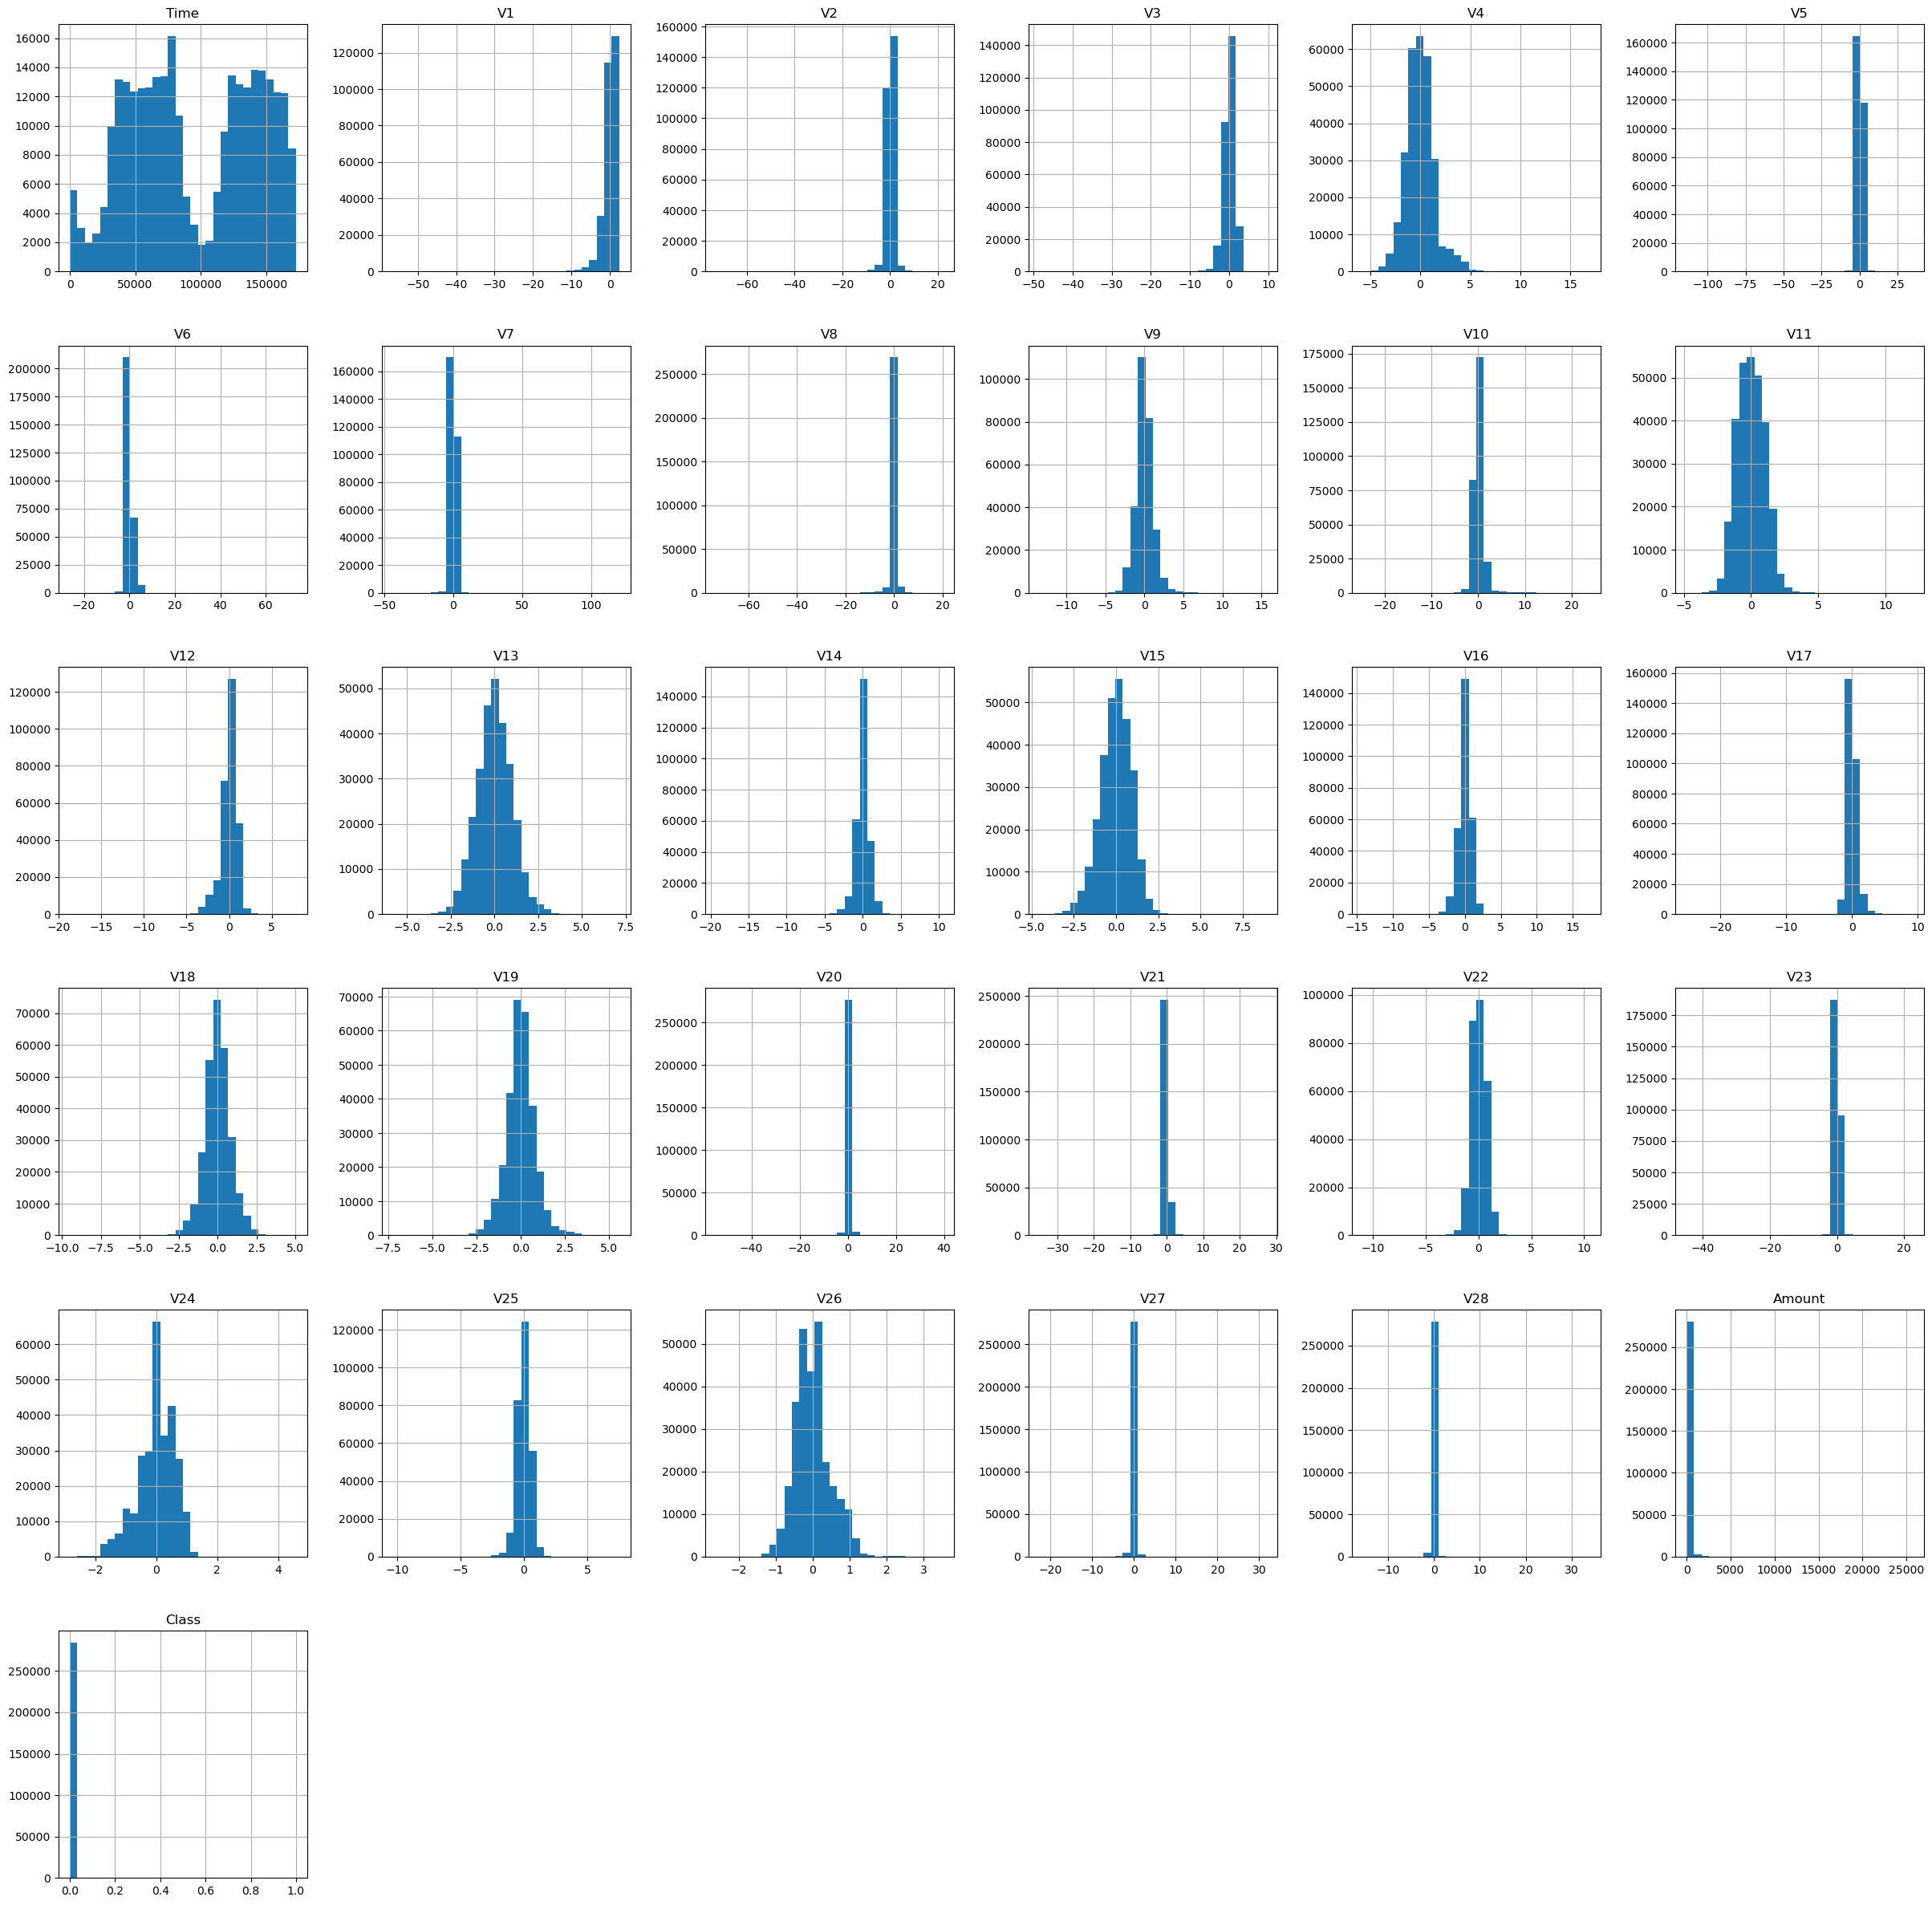

In [6]:
df.hist(bins=30, figsize= (30,30))

In [7]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
scaler = RobustScaler()
scaler2 = MinMaxScaler()

# def scaling(df):
#     df['Amount'] = scaler.fit_transform(df['Amount'].to_numpy().reshape(-1,1))
#     df['Time'] = scaler2.fit_transform(df['Time'].to_numpy().reshape(-1,1))
#     return df

Class
0    284315
1       492
Name: count, dtype: int64


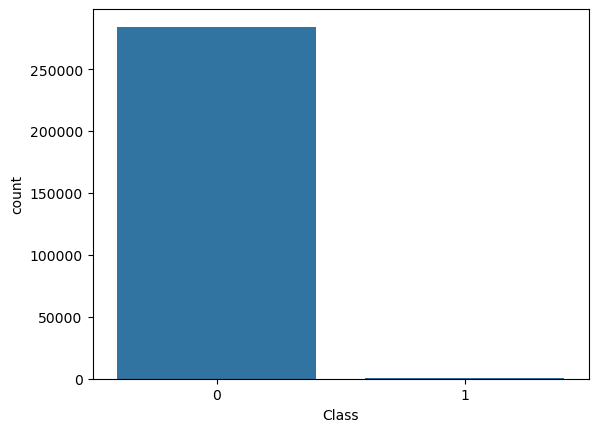

In [9]:
sns.countplot(df, x = 'Class')
print(df['Class'].value_counts())
plt.show()

In [10]:
print(df['Class'].value_counts()[0]/len(df)*100)
print(df['Class'].value_counts()[1]/len(df)*100)

99.82725143693798
0.1727485630620034


<Axes: >

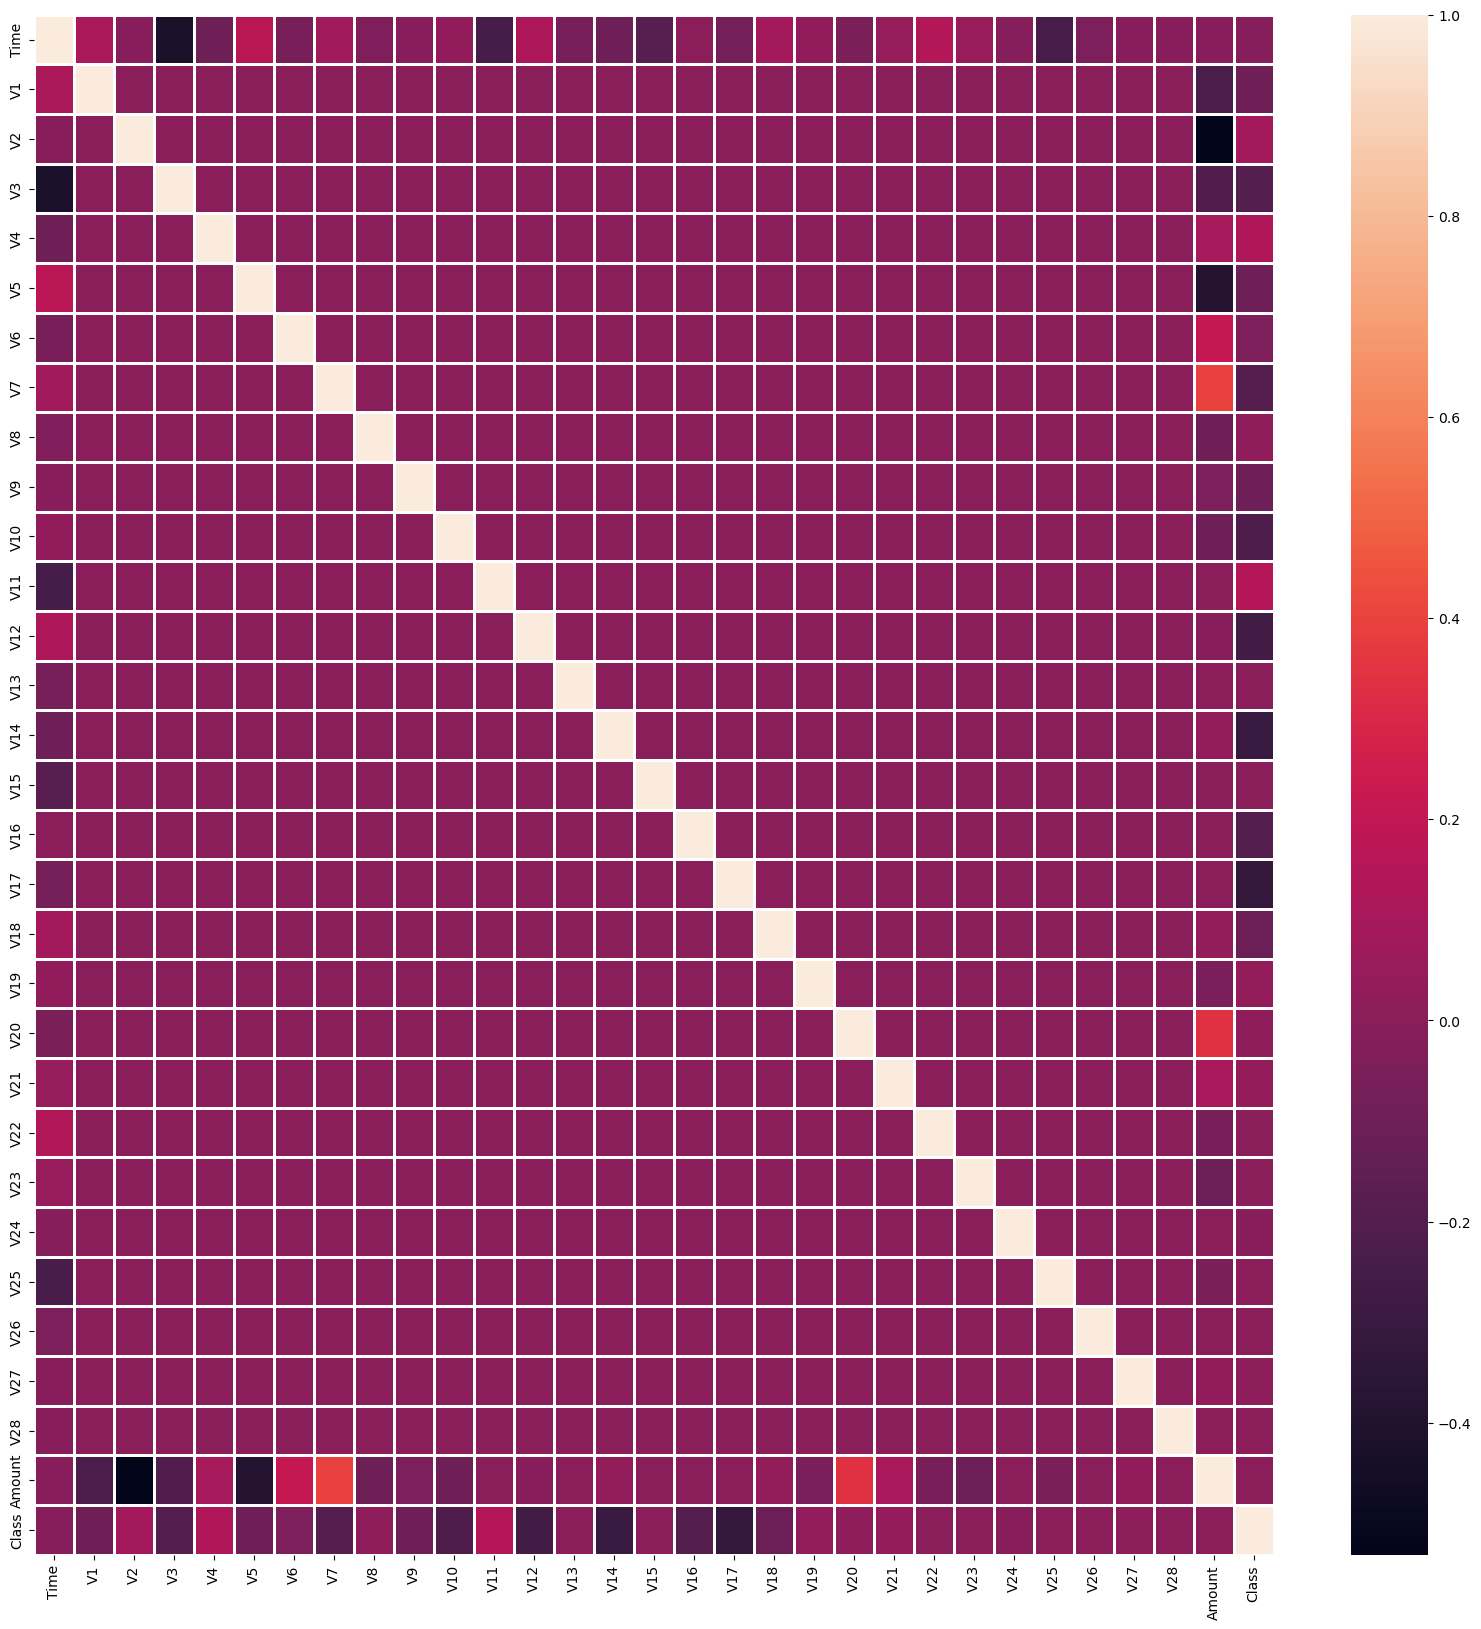

In [11]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), linewidths= 1)

In [12]:
df.corr()['Class']

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

# predict

1. base model
2. deal with the imbalance dataset (imblearn, smote)
    - undersampling: remove random record from majority class. good if have a lot of data.  can cause loss of information
    - oversampling: duplicates random record from minority class. good if dont have a lot of data. can cause overfitting and poor generalization
3. param tuning
4. save model

## 1. base model

In [13]:
from sklearn.model_selection import train_test_split

X , y = df.drop('Class', axis= 1), df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.3, stratify= y, random_state= 2908)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.333, stratify= y_temp, random_state= 2908)

In [14]:
print(y_train.value_counts()[1]/len(y_train)*100)
print(y_val.value_counts()[1]/len(y_val)*100)
print(y_test.value_counts()[1]/len(y_val)*100)

0.17254870488152324
0.17371468678715565
0.08597999649061239


In [15]:
# X_train = scaling(X_train)
# X_val = scaling(X_val)
# X_test = scaling(X_test)

In [16]:
X_train1 = X_train.copy()
X_val1 = X_val.copy()

In [17]:
X_train1['Amount'] = scaler.fit_transform(X_train1['Amount'].to_numpy().reshape(-1,1))
X_val['Amount'] = scaler.transform(X_val['Amount'].to_numpy().reshape(-1,1))

X_train1['Time'] = scaler2.fit_transform(X_train1['Time'].to_numpy().reshape(-1,1))
X_val1['Time'] = scaler2.transform(X_val1['Time'].to_numpy().reshape(-1,1))

In [18]:
# import joblib

# joblib.dump(scaler, 'amount_scaler.pkl')
# joblib.dump(scaler2, 'time_scaler.pkl')

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lr = LogisticRegression(max_iter=10000, random_state= 2908)
rf = RandomForestClassifier(random_state= 2908)
xgb = XGBClassifier(random_state = 2908)
lgbm = LGBMClassifier(random_state = 2908)
cb = CatBoostClassifier(verbose= 10, random_state = 2908)

clfs = [lr, rf, xgb, lgbm, cb]

In [20]:
def result_clsf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    
    print(clf)
    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_val, y_val_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_val, y_val_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_val, y_val_pred ))
    
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    print("AUC :", auc(fpr, tpr))
    print(classification_report(y_val, y_val_pred, target_names = ['not fraud', 'fraud']))
    print(confusion_matrix(y_val, y_val_pred))
    # plt.show()

In [21]:
for clf in clfs:
    result_clsf(clf, X_train1, y_train, X_val1, y_val)

LogisticRegression(max_iter=10000, random_state=2908)
Precision: 0.007252519544127343
Recall: 0.7777777777777778
F1 Score: 0.01437103396789847
AUC : 0.7962556077020579
              precision    recall  f1-score   support

   not fraud       1.00      0.81      0.90     56891
       fraud       0.01      0.78      0.01        99

    accuracy                           0.81     56990
   macro avg       0.50      0.80      0.46     56990
weighted avg       1.00      0.81      0.90     56990

[[46351 10540]
 [   22    77]]
RandomForestClassifier(random_state=2908)
Precision: 0.948051948051948
Recall: 0.7373737373737373
F1 Score: 0.8295454545454545
AUC : 0.8686517137414468
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.95      0.74      0.83        99

    accuracy                           1.00     56990
   macro avg       0.97      0.87      0.91     56990
weighted avg       1.00      1.00      1.00     56

since we want high recall, we continue with xgbclassifier.

## 2. deal with imbalance dataset

### before undersample and oversample

In [22]:
xgb = XGBClassifier(
    # learning_rate = 0.5,
    # max_depth = 4,
    # n_estimator = 200,
    # early_stopping_rounds=10,
    # eval_metric= roc_curve,
    random_state = 2908)

xgb.fit(X_train1,y_train,eval_set=[(X_val1,y_val)],verbose = 10)

y_pred = xgb.predict(X_val1)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_val, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_val, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print("AUC :", auc(fpr, tpr))
print(classification_report(y_val, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_val, y_pred)
print(cfs_mat)

[0]	validation_0-logloss:0.09446
[10]	validation_0-logloss:0.00683
[20]	validation_0-logloss:0.00293
[30]	validation_0-logloss:0.00286
[40]	validation_0-logloss:0.00294
[50]	validation_0-logloss:0.00304
[60]	validation_0-logloss:0.00310
[70]	validation_0-logloss:0.00317
[80]	validation_0-logloss:0.00318
[90]	validation_0-logloss:0.00324
[99]	validation_0-logloss:0.00326
Precision: 0.926829268292683
Recall: 0.7676767676767676
F1 Score: 0.8397790055248618
AUC : 0.883785651420251
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.93      0.77      0.84        99

    accuracy                           1.00     56990
   macro avg       0.96      0.88      0.92     56990
weighted avg       1.00      1.00      1.00     56990

[[56885     6]
 [   23    76]]


In [23]:
def plot_auprc(recall, precision):

    auprc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'Precision-Recall Curve (AUC = {auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # Print the AUPRC
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")

def plot_roc_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

In [24]:
res_df = pd.DataFrame()

In [25]:
def add_res(res_df, dataset, X_train, X_val, y_train, y_val):
    xgb = XGBClassifier(random_state = 2908)    
    xgb.fit(X_train,y_train,eval_set=[(X_val,y_val)], verbose= 20)

    y_pred = xgb.predict(X_val)
    y_pred_prob = xgb.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    
    plot_auprc(recall, precision)
    plot_roc_auc(fpr,tpr)
    print(confusion_matrix(y_val, y_pred))
    
    print(classification_report(y_val, y_pred, target_names = ['not fraud', 'fraud']))
    auprc = auc(recall, precision)
    add_df = pd.DataFrame(
        {'type': [dataset],
         'accuracy': accuracy_score(y_val, y_pred),
         "Precision": precision_score(y_val, y_pred),
         "Recall": recall_score(y_val, y_pred),
         "F1 Score": f1_score(y_val, y_pred),
         'auc': auc(fpr, tpr),
         'aucprc': auprc
         }
    )
    res_df = pd.concat([res_df, add_df])
    return res_df


[0]	validation_0-logloss:0.09446
[20]	validation_0-logloss:0.00296
[40]	validation_0-logloss:0.00299
[60]	validation_0-logloss:0.00321
[80]	validation_0-logloss:0.00331
[99]	validation_0-logloss:0.00340


<Figure size 800x600 with 0 Axes>

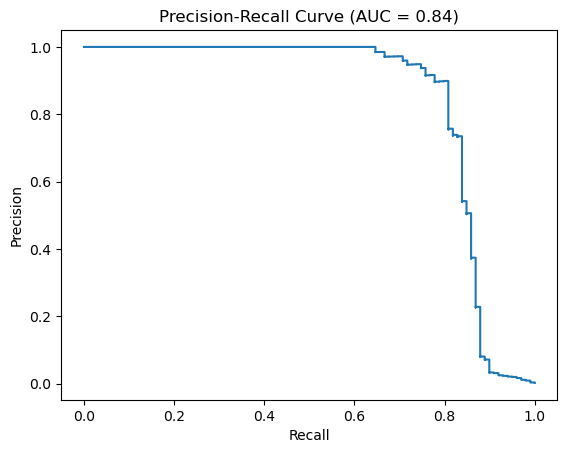

Area Under the Precision-Recall Curve (AUPRC): 0.84


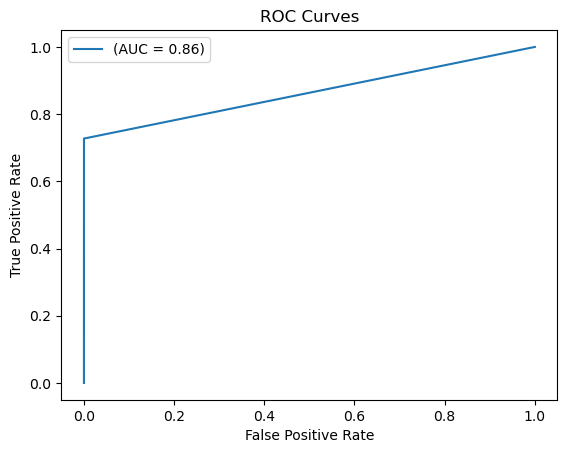

[[56887     4]
 [   27    72]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.95      0.73      0.82        99

    accuracy                           1.00     56990
   macro avg       0.97      0.86      0.91     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697


In [26]:
res_df = add_res(res_df, 'original', X_train1, X_val, y_train, y_val)
res_df

### undersampling
even though doing under sampling on train dataset is not recommended since we will be left on 394*2 data points, we will still do it to see it's preformance on the validation dataset

In [27]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2908)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [29]:
y_under.value_counts()

Class
0    344
1    344
Name: count, dtype: int64

In [30]:
X_val_under = X_val.copy()

In [31]:
X_under['Amount'] = scaler.fit_transform(X_under['Amount'].to_numpy().reshape(-1,1))
X_val_under['Amount'] = scaler.transform(X_val_under['Amount'].to_numpy().reshape(-1,1))

X_under['Time'] = scaler2.fit_transform(X_under['Time'].to_numpy().reshape(-1,1))
X_val_under['Time'] = scaler2.transform(X_val_under['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.49468
[20]	validation_0-logloss:0.13723
[40]	validation_0-logloss:0.12930
[60]	validation_0-logloss:0.13024
[80]	validation_0-logloss:0.13145
[99]	validation_0-logloss:0.13179


<Figure size 800x600 with 0 Axes>

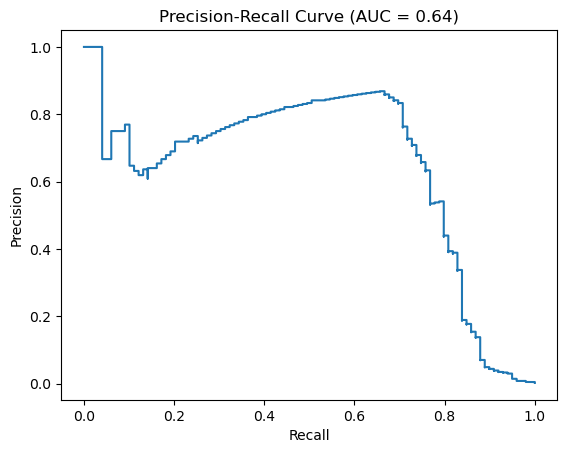

Area Under the Precision-Recall Curve (AUPRC): 0.64


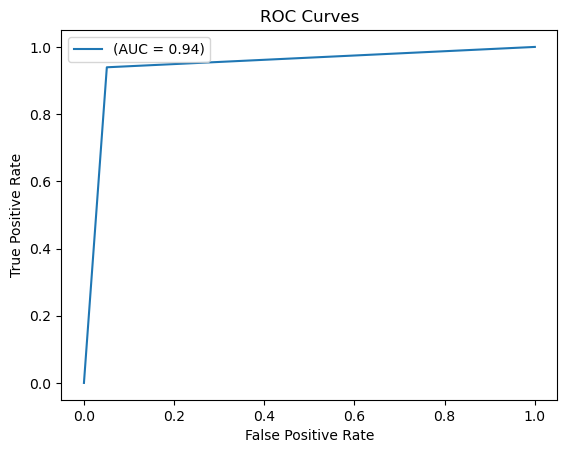

[[54004  2887]
 [    6    93]]
              precision    recall  f1-score   support

   not fraud       1.00      0.95      0.97     56891
       fraud       0.03      0.94      0.06        99

    accuracy                           0.95     56990
   macro avg       0.52      0.94      0.52     56990
weighted avg       1.00      0.95      0.97     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091


In [38]:
res_df = add_res(res_df, 'undersample', X_under, X_val_under, y_under, y_val)
res_df

### oversampling

In [39]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2908)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [40]:
y_over.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

In [42]:
X_val_over = X_val.copy()

In [43]:
X_over['Amount'] = scaler.fit_transform(X_over['Amount'].to_numpy().reshape(-1,1))
X_val_over['Amount'] = scaler.transform(X_val_over['Amount'].to_numpy().reshape(-1,1))

X_over['Time'] = scaler2.fit_transform(X_over['Time'].to_numpy().reshape(-1,1))
X_val_over['Time'] = scaler2.transform(X_val_over['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.45784
[20]	validation_0-logloss:0.00914
[40]	validation_0-logloss:0.00351
[60]	validation_0-logloss:0.00333
[80]	validation_0-logloss:0.00351
[99]	validation_0-logloss:0.00364


<Figure size 800x600 with 0 Axes>

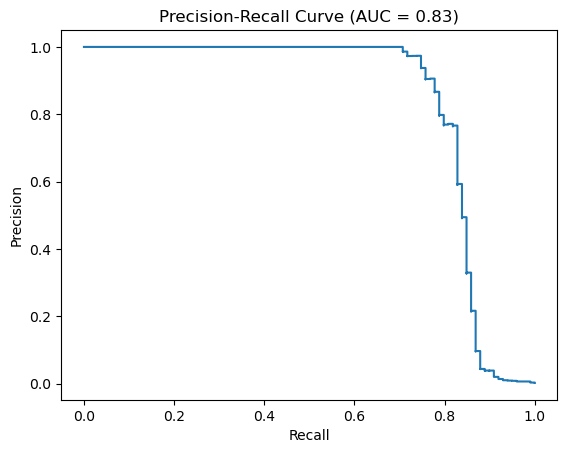

Area Under the Precision-Recall Curve (AUPRC): 0.83


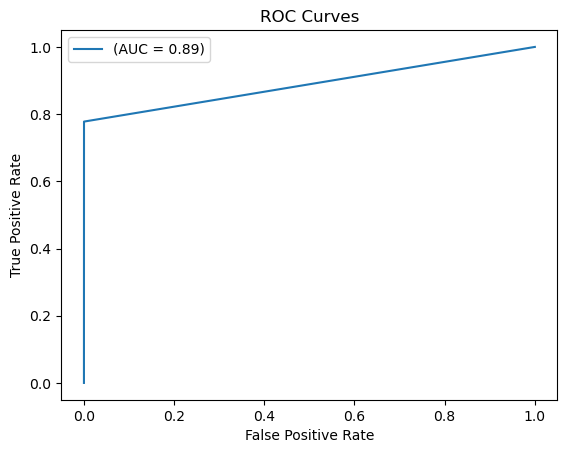

[[56883     8]
 [   22    77]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.91      0.78      0.84        99

    accuracy                           1.00     56990
   macro avg       0.95      0.89      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999474,0.905882,0.777778,0.836957,0.888819,0.833749


In [44]:
res_df = add_res(res_df, 'oversample', X_over, X_val_over, y_over, y_val)
res_df

### oversampling using smote

In [72]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2908)
X_smt, y_smt = sm.fit_resample(X_train, y_train)

In [46]:
y_smt.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

In [47]:
X_val_smt = X_val.copy()

In [48]:
X_smt['Amount'] = scaler.fit_transform(X_smt['Amount'].to_numpy().reshape(-1,1))
X_val_smt['Amount'] = scaler.transform(X_val_smt['Amount'].to_numpy().reshape(-1,1))

X_smt['Time'] = scaler2.fit_transform(X_smt['Time'].to_numpy().reshape(-1,1))
X_val_smt['Time'] = scaler2.transform(X_val_smt['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.45337
[20]	validation_0-logloss:0.01339
[40]	validation_0-logloss:0.00413
[60]	validation_0-logloss:0.00335
[80]	validation_0-logloss:0.00342
[99]	validation_0-logloss:0.00350


<Figure size 800x600 with 0 Axes>

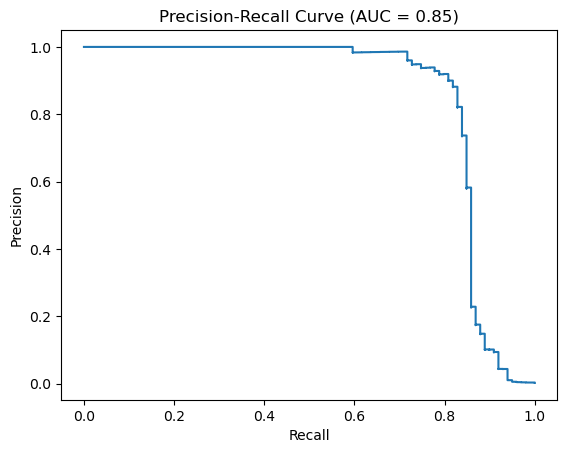

Area Under the Precision-Recall Curve (AUPRC): 0.85


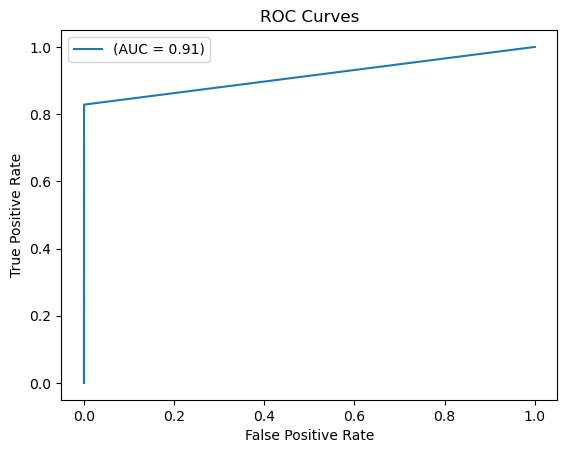

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999474,0.905882,0.777778,0.836957,0.888819,0.833749
0,smote,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
0,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772


In [63]:
res_df = add_res(res_df, 'smote', X_smt, X_val_smt, y_smt, y_val)
res_df

### smotenn
combination of under and over sampling using smotenn. the advantage is smotenn generates less noisy samples compare to smote since smote is interpolating new points betweet marginal outliers and inliers

In [51]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=2908)
X_smtnn, y_smtnn = smote_enn.fit_resample(X_train, y_train)

In [52]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [53]:
y_smtnn.value_counts()

Class
1    191303
0    183732
Name: count, dtype: int64

In [54]:
X_val_smtnn = X_val.copy()

In [55]:
X_smtnn['Amount'] = scaler.fit_transform(X_smtnn['Amount'].to_numpy().reshape(-1,1))
X_val_smtnn['Amount'] = scaler.transform(X_val_smtnn['Amount'].to_numpy().reshape(-1,1))

X_smtnn['Time'] = scaler2.fit_transform(X_smtnn['Time'].to_numpy().reshape(-1,1))
X_val_smtnn['Time'] = scaler2.transform(X_val_smtnn['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.46257
[20]	validation_0-logloss:0.01243
[40]	validation_0-logloss:0.00414
[60]	validation_0-logloss:0.00344
[80]	validation_0-logloss:0.00346
[99]	validation_0-logloss:0.00359


<Figure size 800x600 with 0 Axes>

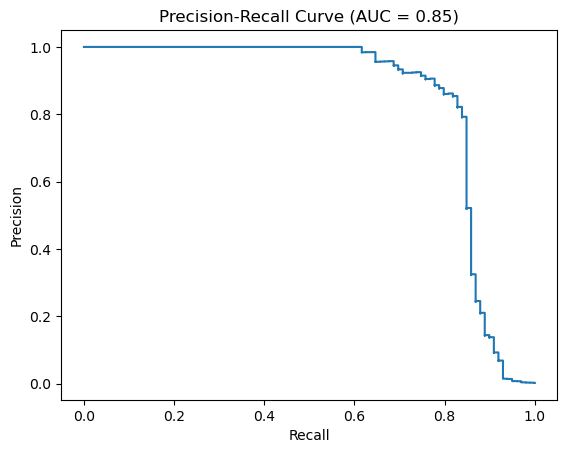

Area Under the Precision-Recall Curve (AUPRC): 0.85


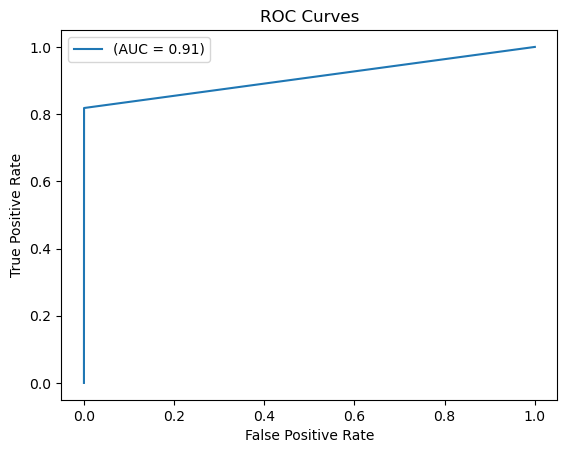

[[56878    13]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.86      0.82      0.84        99

    accuracy                           1.00     56990
   macro avg       0.93      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,oversample,0.999474,0.905882,0.777778,0.836957,0.888819,0.833749
0,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
0,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537


In [56]:
res_df = add_res(res_df, 'smotenn', X_smtnn, X_val_smtnn, y_smtnn, y_val)
res_df

In [68]:
res_df

,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
1,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
2,oversample,0.999474,0.905882,0.777778,0.836957,0.888819,0.833749
4,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
5,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772


### smote with unbalance proportion

In [73]:
from collections import Counter
counts = Counter(y_train)

desired_ratio = 0.5
majority_class = max(counts, key=counts.get)
minority_class = min(counts, key=counts.get)
target_minority_count = int(counts[majority_class] * desired_ratio)

sampling_strategy = {minority_class: target_minority_count}

sm2 = SMOTE(sampling_strategy= sampling_strategy, random_state=2908)

X_smt2, y_smt2 = sm2.fit_resample(X_train, y_train)

In [74]:
y_smt2.value_counts()

Class
0    199020
1     99510
Name: count, dtype: int64

In [75]:
X_val_smt2 = X_val.copy()

In [76]:
X_smt2['Amount'] = scaler.fit_transform(X_smt2['Amount'].to_numpy().reshape(-1,1))
X_val_smt2['Amount'] = scaler.transform(X_val_smt2['Amount'].to_numpy().reshape(-1,1))

X_smt2['Time'] = scaler2.fit_transform(X_smt2['Time'].to_numpy().reshape(-1,1))
X_val_smt2['Time'] = scaler2.transform(X_val_smt2['Time'].to_numpy().reshape(-1,1))

[0]	validation_0-logloss:0.29163
[20]	validation_0-logloss:0.00957
[40]	validation_0-logloss:0.00372
[60]	validation_0-logloss:0.00327
[80]	validation_0-logloss:0.00338
[99]	validation_0-logloss:0.00345


<Figure size 800x600 with 0 Axes>

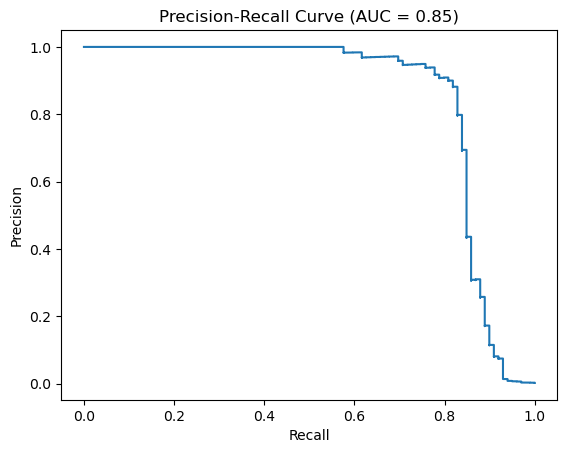

Area Under the Precision-Recall Curve (AUPRC): 0.85


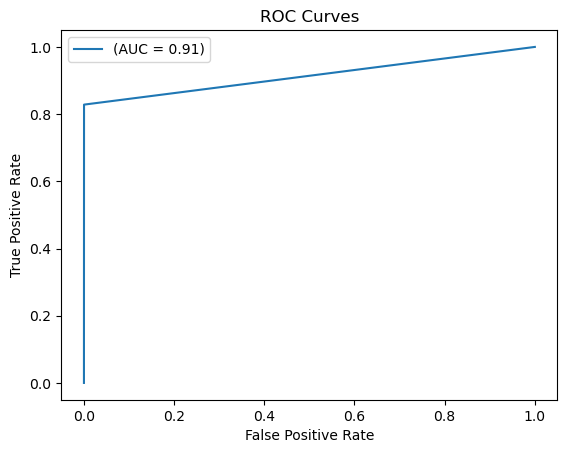

[[56880    11]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990



,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,original,0.999456,0.947368,0.727273,0.822857,0.863601,0.841697
1,undersample,0.949237,0.031208,0.939394,0.060409,0.944324,0.642091
2,oversample,0.999474,0.905882,0.777778,0.836957,0.888819,0.833749
3,smotenn,0.999456,0.861702,0.818182,0.839378,0.908977,0.846537
4,smote,0.999491,0.872340,0.828283,0.849741,0.914036,0.849772
0,smote_imb,0.999509,0.881720,0.828283,0.854167,0.914045,0.849075


In [81]:
res_df = add_res(res_df, 'smote_imb', X_smt2, X_val_smt2, y_smt2, y_val)
res_df

In [84]:
y_train.value_counts(normalize=True)

Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

0.1
[0]	validation_0-logloss:0.13098
[20]	validation_0-logloss:0.00483
[40]	validation_0-logloss:0.00313
[60]	validation_0-logloss:0.00307
[80]	validation_0-logloss:0.00328
[99]	validation_0-logloss:0.00340


<Figure size 800x600 with 0 Axes>

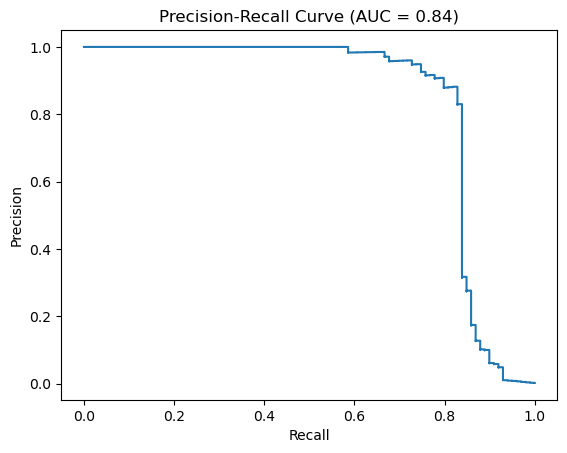

Area Under the Precision-Recall Curve (AUPRC): 0.84


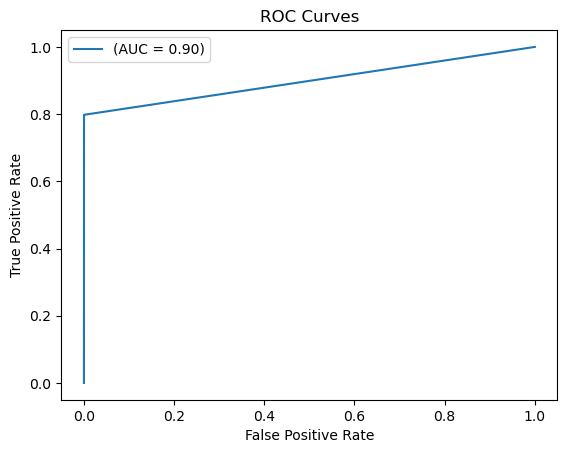

[[56881    10]
 [   20    79]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.89      0.80      0.84        99

    accuracy                           1.00     56990
   macro avg       0.94      0.90      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.2
[0]	validation_0-logloss:0.17105
[20]	validation_0-logloss:0.00607
[40]	validation_0-logloss:0.00304
[60]	validation_0-logloss:0.00289
[80]	validation_0-logloss:0.00302
[99]	validation_0-logloss:0.00313


<Figure size 800x600 with 0 Axes>

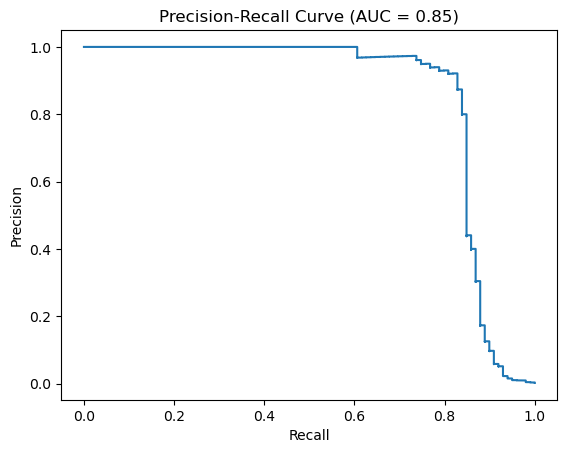

Area Under the Precision-Recall Curve (AUPRC): 0.85


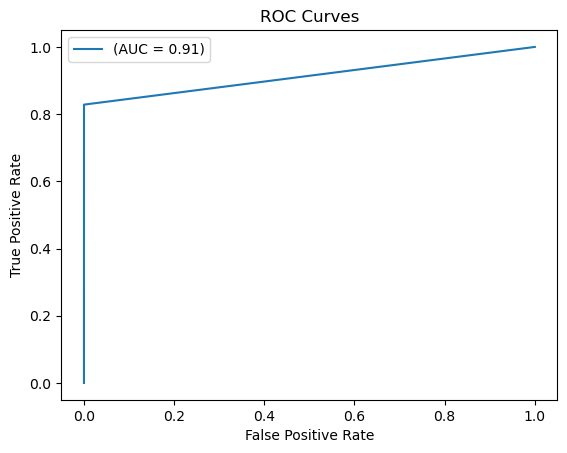

[[56882     9]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.83      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.30000000000000004
[0]	validation_0-logloss:0.21182
[20]	validation_0-logloss:0.00778
[40]	validation_0-logloss:0.00333
[60]	validation_0-logloss:0.00295
[80]	validation_0-logloss:0.00308
[99]	validation_0-logloss:0.00316


<Figure size 800x600 with 0 Axes>

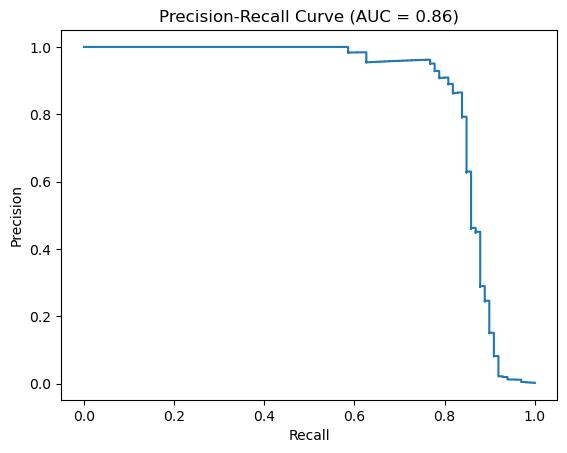

Area Under the Precision-Recall Curve (AUPRC): 0.86


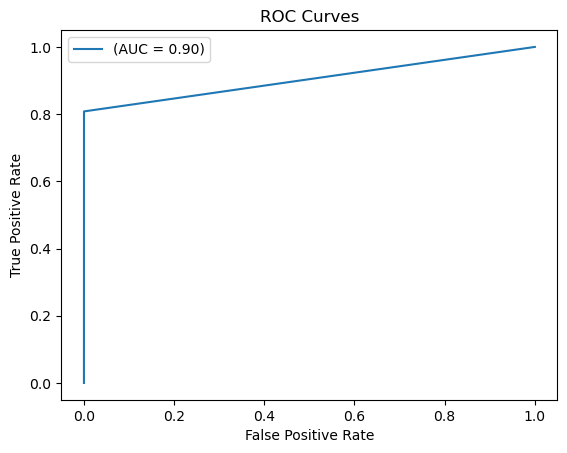

[[56883     8]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.91      0.81      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.90      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.4
[0]	validation_0-logloss:0.25213
[20]	validation_0-logloss:0.00838
[40]	validation_0-logloss:0.00350
[60]	validation_0-logloss:0.00313
[80]	validation_0-logloss:0.00325
[99]	validation_0-logloss:0.00336


<Figure size 800x600 with 0 Axes>

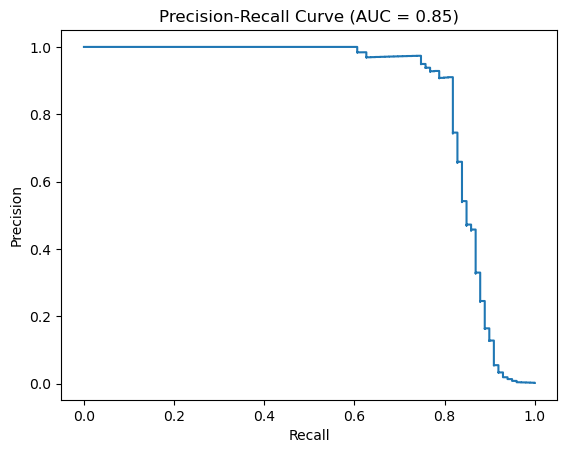

Area Under the Precision-Recall Curve (AUPRC): 0.85


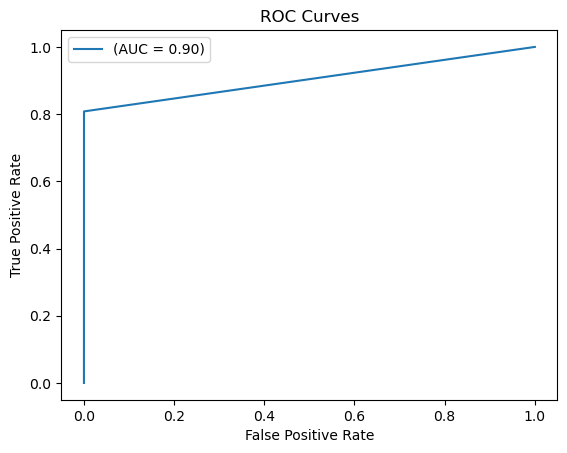

[[56883     8]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.91      0.81      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.90      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.5
[0]	validation_0-logloss:0.29163
[20]	validation_0-logloss:0.00957
[40]	validation_0-logloss:0.00372
[60]	validation_0-logloss:0.00327
[80]	validation_0-logloss:0.00338
[99]	validation_0-logloss:0.00345


<Figure size 800x600 with 0 Axes>

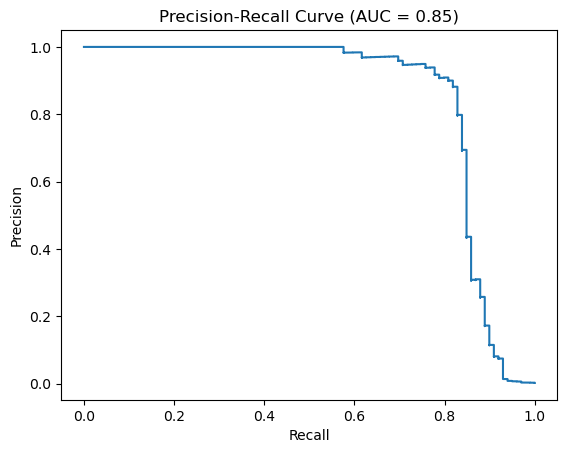

Area Under the Precision-Recall Curve (AUPRC): 0.85


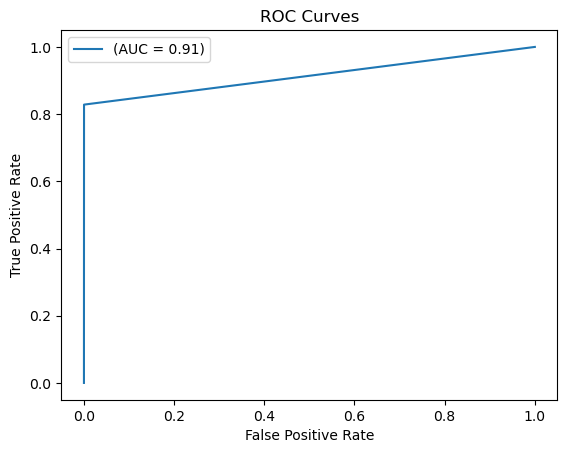

[[56880    11]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.6
[0]	validation_0-logloss:0.32931
[20]	validation_0-logloss:0.01047
[40]	validation_0-logloss:0.00359
[60]	validation_0-logloss:0.00303
[80]	validation_0-logloss:0.00313
[99]	validation_0-logloss:0.00326


<Figure size 800x600 with 0 Axes>

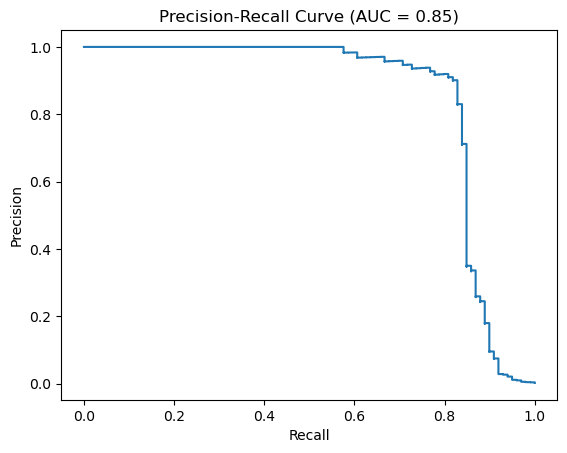

Area Under the Precision-Recall Curve (AUPRC): 0.85


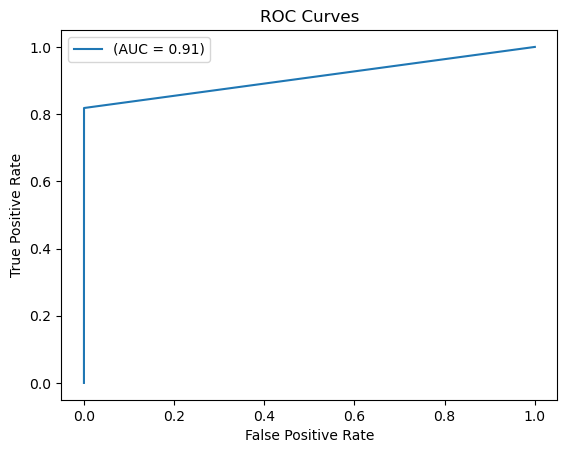

[[56882     9]
 [   18    81]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.90      0.82      0.86        99

    accuracy                           1.00     56990
   macro avg       0.95      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.7000000000000001
[0]	validation_0-logloss:0.36304
[20]	validation_0-logloss:0.01133
[40]	validation_0-logloss:0.00441
[60]	validation_0-logloss:0.00344
[80]	validation_0-logloss:0.00349
[99]	validation_0-logloss:0.00358


<Figure size 800x600 with 0 Axes>

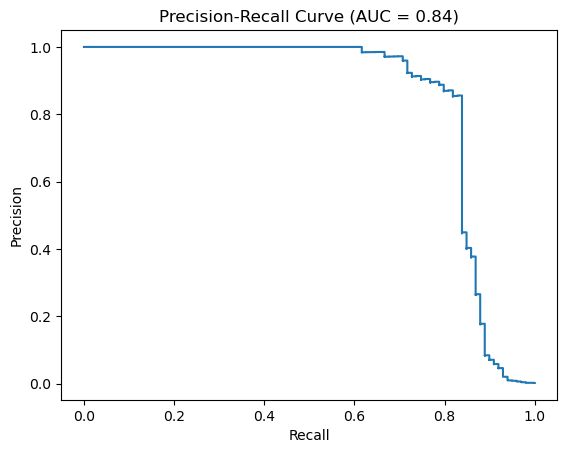

Area Under the Precision-Recall Curve (AUPRC): 0.84


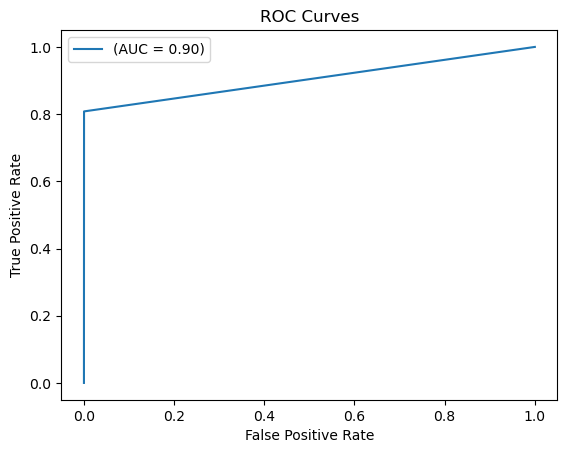

[[56879    12]
 [   19    80]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.81      0.84        99

    accuracy                           1.00     56990
   macro avg       0.93      0.90      0.92     56990
weighted avg       1.00      1.00      1.00     56990

0.8
[0]	validation_0-logloss:0.39547
[20]	validation_0-logloss:0.01206
[40]	validation_0-logloss:0.00400
[60]	validation_0-logloss:0.00322
[80]	validation_0-logloss:0.00327
[99]	validation_0-logloss:0.00339


<Figure size 800x600 with 0 Axes>

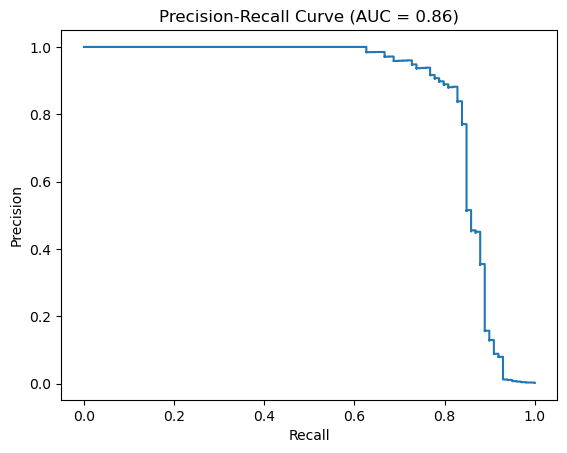

Area Under the Precision-Recall Curve (AUPRC): 0.86


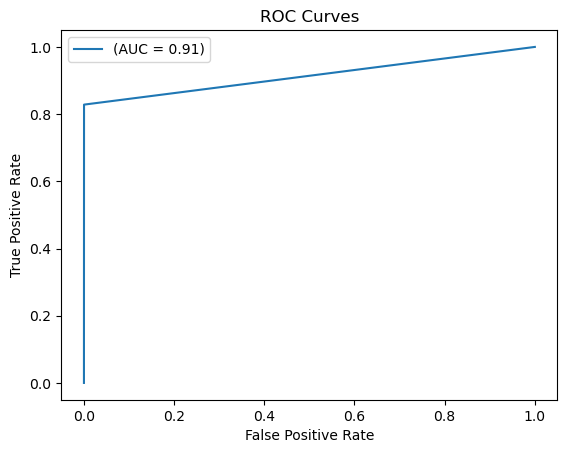

[[56880    11]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.88      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.93     56990
weighted avg       1.00      1.00      1.00     56990

0.9
[0]	validation_0-logloss:0.42602
[20]	validation_0-logloss:0.01234
[40]	validation_0-logloss:0.00413
[60]	validation_0-logloss:0.00329
[80]	validation_0-logloss:0.00331
[99]	validation_0-logloss:0.00346


<Figure size 800x600 with 0 Axes>

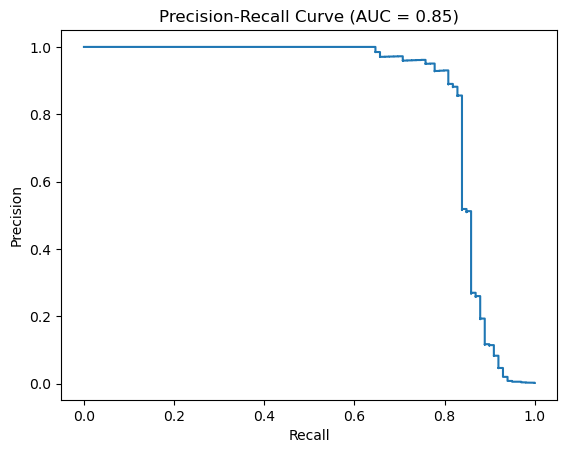

Area Under the Precision-Recall Curve (AUPRC): 0.85


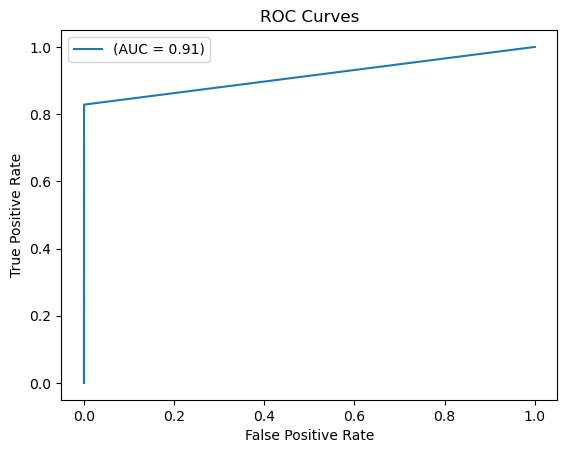

[[56879    12]
 [   17    82]]
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.87      0.83      0.85        99

    accuracy                           1.00     56990
   macro avg       0.94      0.91      0.92     56990
weighted avg       1.00      1.00      1.00     56990



In [89]:
dummy_df = pd.DataFrame()
for i in range(0, 9):
    print(0.1 + 0.1*i)
    desired_ratio = 0.1 + 0.1*i
    target_minority_count = int(counts[majority_class] * desired_ratio)
    sampling_strategy = {minority_class: target_minority_count}
    sm2 = SMOTE(sampling_strategy= sampling_strategy, random_state=2908)
    X_smt2, y_smt2 = sm2.fit_resample(X_train, y_train)

    X_val_smt2 = X_val.copy()

    X_smt2['Amount'] = scaler.fit_transform(X_smt2['Amount'].to_numpy().reshape(-1,1))
    X_val_smt2['Amount'] = scaler.transform(X_val_smt2['Amount'].to_numpy().reshape(-1,1))

    X_smt2['Time'] = scaler2.fit_transform(X_smt2['Time'].to_numpy().reshape(-1,1))
    X_val_smt2['Time'] = scaler2.transform(X_val_smt2['Time'].to_numpy().reshape(-1,1))

    dummy_df = add_res(dummy_df, 'ratio '+ str(desired_ratio), X_smt2, X_val_smt2, y_smt2, y_val)

In [90]:
dummy_df

,type,accuracy,Precision,Recall,F1 Score,auc,aucprc
0,ratio 0.1,0.999474,0.887640,0.797980,0.840426,0.898902,0.837077
0,ratio 0.2,0.999544,0.901099,0.828283,0.863158,0.914062,0.852963
0,ratio 0.30000000000000004,0.999526,0.909091,0.808081,0.855615,0.903970,0.856961
0,ratio 0.4,0.999526,0.909091,0.808081,0.855615,0.903970,0.848099
0,ratio 0.5,0.999509,0.881720,0.828283,0.854167,0.914045,0.849075
0,ratio 0.6,0.999526,0.900000,0.818182,0.857143,0.909012,0.847536
0,ratio 0.7000000000000001,0.999456,0.869565,0.808081,0.837696,0.903935,0.842630
0,ratio 0.8,0.999509,0.881720,0.828283,0.854167,0.914045,0.855732
0,ratio 0.9,0.999491,0.872340,0.828283,0.849741,0.914036,0.849545


from the result table above, by comparing the recall, precision, and F1 score, we are pretty happy with the result of oversampling using smote. 

## 3. dimensionality reduction

## correlation

<Axes: >

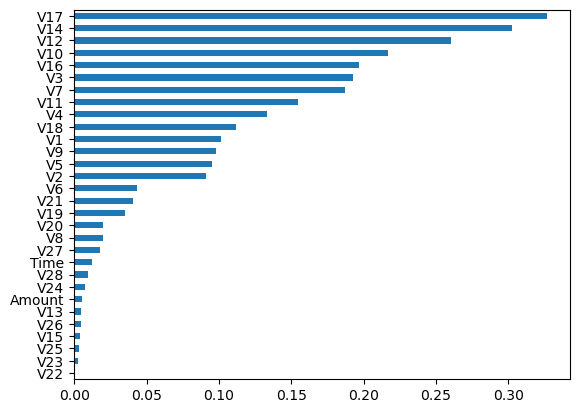

In [319]:
df.corr().drop('Class')['Class'].abs().sort_values().plot(kind = 'barh',)

In [320]:
df.corr().drop('Class')['Class'].abs().sort_values()

V22       0.000805
V23       0.002685
V25       0.003308
V15       0.004223
V26       0.004455
V13       0.004570
Amount    0.005632
V24       0.007221
V28       0.009536
Time      0.012323
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V6        0.043643
V2        0.091289
V5        0.094974
V9        0.097733
V1        0.101347
V18       0.111485
V4        0.133447
V11       0.154876
V7        0.187257
V3        0.192961
V16       0.196539
V10       0.216883
V12       0.260593
V14       0.302544
V17       0.326481
Name: Class, dtype: float64

In [321]:
correlation_col = list(df.corr().drop('Class')['Class'].abs().sort_values(ascending=False).index)
res_corr = pd.DataFrame({'num feature': [],
                       "Precision": [],
                       "Recall": [],
                       "F1 Score": []})
for i in range(1,len(correlation_col)):
    num_feat = i

    X_train_cor, X_val_cor, X_test_cor = X_smt.copy(), X_val.copy(), X_test.copy()
    X_train_cor = X_train_cor[correlation_col[:i]]
    X_val_cor = X_val_cor[correlation_col[:i]]
    X_test_cor = X_test_cor[correlation_col[:i]]

    print('num_feat:' + str(len(correlation_col[:i])))
    print(correlation_col[:i])
    print()
    xgb = XGBClassifier(
        learning_rate = 0.5,
        max_depth =4,
        # n_estimator = 200,
        early_stopping_rounds=10,
        # eval_metric= roc_auc_score,
        random_state = 2908)

    xgb.fit(X_train_cor,y_smt,eval_set=[(X_val_cor,y_val)], verbose= 0
            )
    y_pred = xgb.predict(X_test_cor)

    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_test, y_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_test, y_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
    # cfs_mat = confusion_matrix(y_test, y_pred)
    # print(cfs_mat)
    new_row = {'num feature': i,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)}
    res_corr.loc[len(res_corr)] = new_row

res_corr

num_feat:1
['V17']

Precision: 0.035480859010270774
Recall: 0.7755102040816326
F1 Score: 0.06785714285714285
num_feat:2
['V17', 'V14']

Precision: 0.06965174129353234
Recall: 0.8571428571428571
F1 Score: 0.12883435582822086
num_feat:3
['V17', 'V14', 'V12']

Precision: 0.07056798623063683
Recall: 0.8367346938775511
F1 Score: 0.13015873015873014
num_feat:4
['V17', 'V14', 'V12', 'V10']

Precision: 0.06932409012131716
Recall: 0.8163265306122449
F1 Score: 0.12779552715654952
num_feat:5
['V17', 'V14', 'V12', 'V10', 'V16']

Precision: 0.08764044943820225
Recall: 0.7959183673469388
F1 Score: 0.15789473684210525
num_feat:6
['V17', 'V14', 'V12', 'V10', 'V16', 'V3']

Precision: 0.10666666666666667
Recall: 0.8163265306122449
F1 Score: 0.18867924528301888
num_feat:7
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7']

Precision: 0.13978494623655913
Recall: 0.7959183673469388
F1 Score: 0.23780487804878048
num_feat:8
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11']

Precision: 0.1813953488372093
Re

,num feature,Precision,Recall,F1 Score
0,1,0.035481,0.775510,0.067857
1,2,0.069652,0.857143,0.128834
2,3,0.070568,0.836735,0.130159
3,4,0.069324,0.816327,0.127796
4,5,0.087640,0.795918,0.157895
5,6,0.106667,0.816327,0.188679
6,7,0.139785,0.795918,0.237805
7,8,0.181395,0.795918,0.295455
8,9,0.248408,0.795918,0.378641
9,10,0.280576,0.795918,0.414894


c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

Text(0, 0.5, 'score')

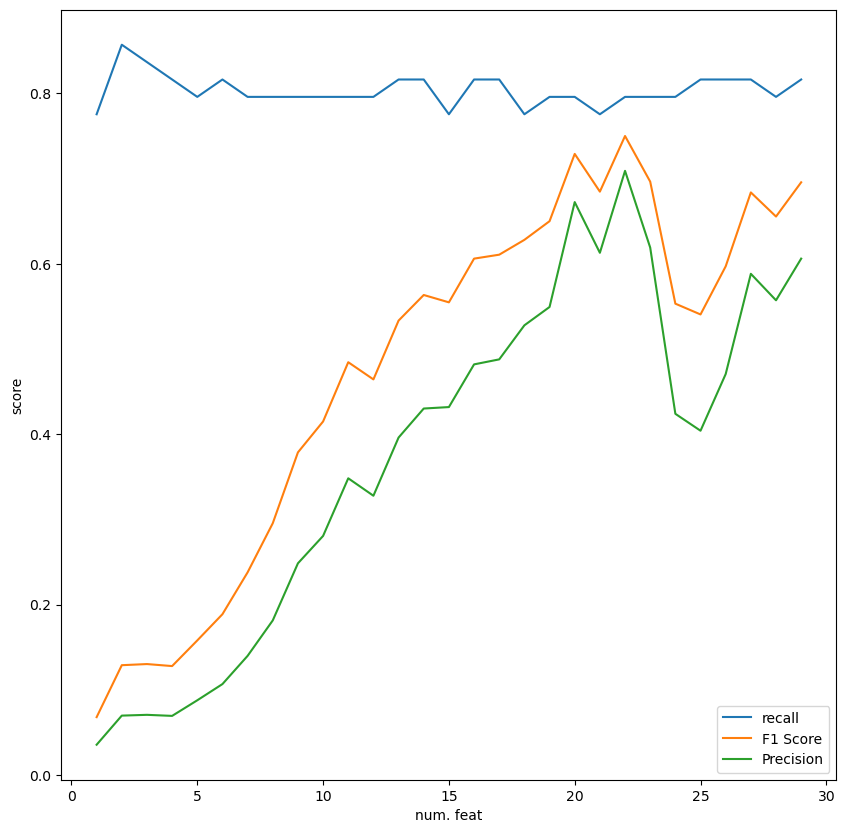

In [322]:
plt.figure(figsize=(10,10))
sns.lineplot(res_corr, x = 'num feature', y = 'Recall', label = 'recall')
sns.lineplot(res_corr, x = 'num feature', y = 'F1 Score', label = 'F1 Score')
sns.lineplot(res_corr, x = 'num feature', y = 'Precision', label = 'Precision')
plt.xlabel('num. feat')
plt.ylabel('score')

In [325]:
res_corr['F1 Score'].max()

0.75

by this technique, turns out using all of the columns produces the highes recall, precision, and f1

## variance

In [323]:
variance = X_train.var().sort_values()


In [324]:
tresh = [0.1,0.2,0.5,0.8,1,2,3]

res_var = pd.DataFrame({'tresh': [],
                       "Precision": [],
                       "Recall": [],
                       "F1 Score": []})
for i in tresh:
    filtered_col = list(variance[variance >= i].index)
    X_train_cor, X_val_cor, X_test_cor = X_smt.copy(), X_val.copy(), X_test.copy()
    X_train_cor = X_train_cor[filtered_col]
    X_val_cor = X_val_cor[filtered_col]
    X_test_cor = X_test_cor[filtered_col]

    print('num_feat:' + str(len(filtered_col)))
    print('tresh:' +str(i) )
    
    print(filtered_col)
    print()
    xgb = XGBClassifier(
        learning_rate = 0.5,
        max_depth =4,
        # n_estimator = 200,
        early_stopping_rounds=10,
        # eval_metric= roc_auc_score,
        random_state = 2908)

    xgb.fit(X_train_cor,y_smt,eval_set=[(X_val_cor,y_val)], verbose= 0
            )
    y_pred = xgb.predict(X_test_cor)

    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_test, y_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_test, y_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
    # cfs_mat = confusion_matrix(y_test, y_pred)
    # print(cfs_mat)
    print()
    new_row = {'tresh': i,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)}
    res_var.loc[len(res_var)] = new_row

res_var

num_feat:29
tresh:0.1
['V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.5633802816901409
Recall: 0.8163265306122449
F1 Score: 0.6666666666666666

num_feat:27
tresh:0.2
['V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.5633802816901409
Recall: 0.8163265306122449
F1 Score: 0.6666666666666666

num_feat:23
tresh:0.5
['V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.47619047619047616
Recall: 0.8163265306122449
F1 Score: 0.6015037593984961

num_feat:16
tresh:0.8
['V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

P

,tresh,Precision,Recall,F1 Score
0,0.1,0.563380,0.816327,0.666667
1,0.2,0.563380,0.816327,0.666667
2,0.5,0.476190,0.816327,0.601504
3,0.8,0.404040,0.816327,0.540541
4,1.0,0.236686,0.816327,0.366972
5,2.0,0.042599,0.816327,0.080972
6,3.0,0.007705,0.775510,0.015258
